# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
import tensorflow as tf
import tensorflow_datasets
from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors,
)
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


# local packages
import utils.model_metrics  as model_metrics

In [2]:
import importlib
importlib.reload(model_metrics);

In [3]:
# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [4]:
data, info = tensorflow_datasets.load(name='glue/sst2',with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/sst2/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/glue/sst2/1.0.0


In [5]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Stanford Sentiment Treebank consists of sentences from movie reviews and
            human annotations of their sentiment. The task is to predict the sentiment of a
            given sentence. We use the two-way (positive/negative) class split, and use only
            sentence-level labels.',
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=70042,
    splits={
        'test': 1821,
        'train': 67349,
        'validation': 872,
    },
    supervised_keys=None,
    citation="""@

In [6]:
info.features["label"].names

['negative', 'positive']

In [7]:
info.features["label"].num_classes

2

In [8]:
data

{'test': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'train': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'validation': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>}

In [9]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [10]:
data['train']

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [11]:
from tensorflow.python.data.ops import dataset_ops
dataset_ops.get_legacy_output_shapes(data['train'])

{'idx': TensorShape([]), 'label': TensorShape([]), 'sentence': TensorShape([])}

In [12]:
dataset_ops.get_legacy_output_types(data['train'])

{'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}

In [13]:
dataset_ops.get_legacy_output_classes(data['train'])

{'idx': tensorflow.python.framework.ops.Tensor,
 'label': tensorflow.python.framework.ops.Tensor,
 'sentence': tensorflow.python.framework.ops.Tensor}

In [14]:
for l in data['train']:
    print(l.keys())
    print(l)
    print(l['idx'])
    print(l['label'])
    print(l['sentence'])
    break

dict_keys(['idx', 'label', 'sentence'])
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sentence': <tf.Tensor: shape=(), dtype=string, numpy=b'for the uninitiated plays better on video with the sound '>}
tf.Tensor(16399, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)


In [15]:
np_array=np.array(list(data['train'].as_numpy_iterator()))

In [16]:
i = 0
for element in np_array: 
    print(element) 
    i += 1
    if i > 10:
        break
    

{'idx': 16399, 'label': 0, 'sentence': b'for the uninitiated plays better on video with the sound '}
{'idx': 1680, 'label': 0, 'sentence': b'like a giant commercial for universal studios , where much of the action takes place '}
{'idx': 47917, 'label': 1, 'sentence': b'company once again dazzle and delight us '}
{'idx': 17307, 'label': 1, 'sentence': b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "}
{'idx': 27051, 'label': 0, 'sentence': b', this cross-cultural soap opera is painfully formulaic and stilted . '}
{'idx': 67082, 'label': 1, 'sentence': b", the film is n't nearly as downbeat as it sounds , but strikes a tone that 's alternately melancholic , hopeful and strangely funny . "}
{'idx': 54784, 'label': 0, 'sentence': b'only masochistic moviegoers need apply . '}
{'idx': 50543, 'label': 1, 'sentence': b'convince almost everyone that it was put on the screen , just for them '}
{'idx': 48736, '

In [17]:
np_array[:5]

array([{'idx': 16399, 'label': 0, 'sentence': b'for the uninitiated plays better on video with the sound '},
       {'idx': 1680, 'label': 0, 'sentence': b'like a giant commercial for universal studios , where much of the action takes place '},
       {'idx': 47917, 'label': 1, 'sentence': b'company once again dazzle and delight us '},
       {'idx': 17307, 'label': 1, 'sentence': b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "},
       {'idx': 27051, 'label': 0, 'sentence': b', this cross-cultural soap opera is painfully formulaic and stilted . '}],
      dtype=object)

In [18]:
np.shape(np_array)

(67349,)

In [19]:
len(np_array)

67349

In [20]:
np_array[0]

{'idx': 16399,
 'label': 0,
 'sentence': b'for the uninitiated plays better on video with the sound '}

In [21]:
# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='sst-2')
train_dataset_batch = train_dataset.shuffle(100).batch(32).repeat(2)
valid_dataset_batch = valid_dataset.batch(64)

In [22]:
train_dataset_batch

<RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [23]:
list(train_dataset.take(1).as_numpy_iterator())

[({'input_ids': array([  101,  1111,  1103,  8362,  4729, 10691,  1906,  2399,  1618,
           1113,  1888,  1114,  1103,  1839,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0, 

In [24]:
list(tensorflow_datasets.as_numpy(train_dataset))[:2]

[({'input_ids': array([  101,  1111,  1103,  8362,  4729, 10691,  1906,  2399,  1618,
           1113,  1888,  1114,  1103,  1839,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0, 

In [25]:
list(valid_dataset.take(1).as_numpy_iterator())

[({'input_ids': array([  101,   170,  2860,  2008,  5102,  7782,   185,  5024,  1389,
           1106,  5250,  3163,  1223, 16674,  1118,  1103,   183,  2822,
            119,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0, 

In [26]:
valid_dataset

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [27]:
train_dataset

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [28]:
np_train_array=np.array(list(train_dataset_batch.as_numpy_iterator()))

In [29]:
np_train_dataset=list(train_dataset.as_numpy_iterator())

In [30]:
len(np_train_dataset)

67349

In [31]:
np_train_array.shape

(4210, 2)

In [32]:
np_train_array[0][1].shape

(32,)

In [33]:
#sample size/batch size and repeat 2 times
math.ceil((67349/32)*2)

4210

In [34]:
# label
np_train_array[0][1]

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [35]:
np_train_dataset[0][0].keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])

In [36]:
np_train_dataset[0][0]

{'input_ids': array([  101,  1111,  1103,  8362,  4729, 10691,  1906,  2399,  1618,
         1113,  1888,  1114,  1103,  1839,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [37]:
np_train_array[0][0]['input_ids'][0]

array([ 101, 1103, 2322,  118, 5126, 3181,  102,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [38]:
for i in np_train_array[0][0]['input_ids'][0]:
    print('{:7d}    ---->    {}'.format(i, tokenizer.decode(int(i))))

    101    ---->    [ C L S ]
   1103    ---->    t h e
   2322    ---->    c a m p a i g n
    118    ---->    -
   5126    ---->    t r a i l
   3181    ---->    p r e s s
    102    ---->    [ S E P ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->    [ P A D ]
      0    ---->

In [39]:
np_train_dataset[0][0]['input_ids']

array([  101,  1111,  1103,  8362,  4729, 10691,  1906,  2399,  1618,
        1113,  1888,  1114,  1103,  1839,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [40]:
np_train_dataset[0][0]['input_ids'].shape

(128,)

In [41]:
np_train_dataset[0][0]['attention_mask']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [42]:
np_train_array[0][0]['attention_mask'].shape

(32, 128)

In [43]:
np_train_array[0][0]['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [44]:
np_train_array[0][0]['token_type_ids'].shape

(32, 128)

In [45]:
text=np_array[0]['sentence'].decode("utf-8") 

In [46]:
text

'for the uninitiated plays better on video with the sound '

In [47]:
for word in text.split(' ') :
    print('{:10}    ---->    {}'.format(word, tokenizer.encode(word)))

for           ---->    [101, 1111, 102]
the           ---->    [101, 1103, 102]
uninitiated    ---->    [101, 8362, 4729, 10691, 1906, 102]
plays         ---->    [101, 2399, 102]
better        ---->    [101, 1618, 102]
on            ---->    [101, 1113, 102]
video         ---->    [101, 1888, 102]
with          ---->    [101, 1114, 102]
the           ---->    [101, 1103, 102]
sound         ---->    [101, 1839, 102]
              ---->    [101, 102]


In [48]:
for i in tokenizer.encode(text):
    print('{:7d}    ---->    {}'.format(i, tokenizer.decode(int(i))))

    101    ---->    [ C L S ]
   1111    ---->    f o r
   1103    ---->    t h e
   8362    ---->    u n
   4729    ---->    # # i n i
  10691    ---->    # # t i a
   1906    ---->    # # t e d
   2399    ---->    p l a y s
   1618    ---->    b e t t e r
   1113    ---->    o n
   1888    ---->    v i d e o
   1114    ---->    w i t h
   1103    ---->    t h e
   1839    ---->    s o u n d
    102    ---->    [ S E P ]


In [49]:
len(tokenizer.encode(text))

15

In [50]:
model_2 = TFBertForSequenceClassification.from_pretrained('bert-base-cased')
model_4 = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=4)

In [51]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_2.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_4.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [52]:
model_2.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_2.inputs

[]

In [54]:
model_2.outputs

[]

In [55]:
model_2.layers

In [56]:
for layer in model_2.layers:
    print(layer.name, layer.inbound_nodes, layer.outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


In [57]:
for i in model_2.layers:
    print(i.inbound_nodes)

[]
[]
[]


In [58]:
model_2.layers[0].inbound_nodes

[]

In [59]:
dir(model_2.layers[2])

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_attribute_sentinel',
 '_autocast',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_collect_input_masks',
 '_compute_dtype',
 '_dedup_weights',
 '_deferred_dependencies',
 '_dtype',
 '_dtype_defaulted_to_floatx',
 '_dtype_policy',
 '_dynamic',
 '_eager_add_metric',
 '_eager_losses',
 '_expects_mask_arg',
 '_expects_training_arg

In [60]:
# Train and evaluate using tf.keras.Model.fit()
history_2 = model_2.fit(train_dataset_batch, epochs=2, steps_per_epoch=10)


Train for 10 steps
Epoch 1/2
10/10 [==============================] - 336s 34s/step - loss: 0.6603 - accuracy: 0.6062
Epoch 2/2
10/10 [==============================] - 298s 30s/step - loss: 0.5682 - accuracy: 0.7156


In [61]:
history_4 = model_4.fit(train_dataset_batch, epochs=2, steps_per_epoch=10)


Train for 10 steps
Epoch 1/2
10/10 [==============================] - 333s 33s/step - loss: 1.3865 - accuracy: 0.3000
Epoch 2/2
10/10 [==============================] - 298s 30s/step - loss: 0.8561 - accuracy: 0.5906


In [62]:
model_2.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [63]:
history_2.epoch

[0, 1]

In [64]:
history_2.history

{'loss': [0.6602770328521729, 0.5682326197624207],
 'accuracy': [0.60625, 0.715625]}

In [65]:
np.shape(list((valid_dataset_batch).as_numpy_iterator())[0][1])

(64,)

In [66]:
np_valid_dataset = list((valid_dataset_batch).as_numpy_iterator())[0][1]
len(np_valid_dataset)

64

In [67]:
# prediction
y_hat_2 = model_2.predict(valid_dataset_batch)
#y_hat = model.predict_on_batch(valid_dataset)

In [68]:
y_hat_4 = model_4.predict(valid_dataset_batch)

In [69]:
y_hat_2

#y_hat.shape
# using the whole dataset
# for 4 categories: (872,4)
# for 2 categories: (872,2)

array([[-0.7738919 ,  0.30267423],
       [-0.6332481 ,  0.06294108],
       [-0.24078533, -0.7245116 ],
       ...,
       [-0.9456006 ,  0.8402885 ],
       [-0.4257586 , -0.33841658],
       [-0.8196051 ,  0.38295242]], dtype=float32)

In [70]:
y_hat_4

array([[ 1.1233698 ,  1.0862385 , -1.1531808 , -0.875806  ],
       [ 1.0463811 ,  1.2987903 , -1.1533064 , -0.94067997],
       [ 1.1344936 ,  0.5214642 , -0.9104535 , -0.62809724],
       ...,
       [ 0.7448484 ,  1.5976157 , -1.2212645 , -1.0037866 ],
       [ 0.9065665 ,  1.4701813 , -1.3181516 , -1.0046307 ],
       [ 1.0439866 ,  1.2180257 , -1.2309015 , -0.94497764]],
      dtype=float32)

In [71]:
# confusion matrix
predict_index_2 = np.argmax(y_hat_2, axis=1)
#predict_index = np.argmax(y_hat, axis=2)
# for 4 categories: categories 2 and 3 never get picked (which was to be hoped)
# for 2 categories: always 1, lots of negative values

In [72]:
predict_index_2

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,

In [73]:
predict_index_4 = np.argmax(y_hat_4, axis=1)

In [74]:
predict_index_4

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,

In [75]:
np_valid_array = np.array(list(valid_dataset_batch.as_numpy_iterator()))
true_index = []
for batch in range(0,np_valid_array.shape[0]):
    true_index.append(np_valid_array[batch][1])


In [76]:
range(0,np_valid_array.shape[0])

range(0, 14)

In [77]:
true_index = np.concatenate(true_index)

In [78]:
#true_index = np_valid_dataset[0][1]
true_index

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,

In [79]:
print(len(predict_index_2))
print(len(predict_index_4))
print(len(true_index))

872
872
872


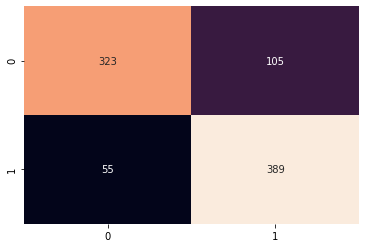

In [80]:
sns.heatmap(confusion_matrix(true_index, predict_index_2), 
            annot=True, cbar=False, fmt='d')#, ax=ax)

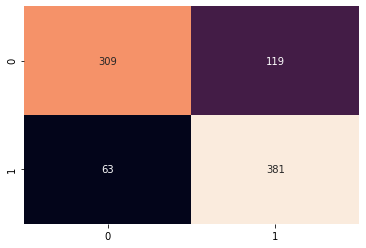

In [81]:
sns.heatmap(confusion_matrix(true_index, predict_index_4), 
            annot=True, cbar=False, fmt='d')#, ax=ax)

In [82]:
input_layer = tf.keras.Input(shape = (128,), dtype='int64')  
bert_ini = TFBertModel.from_pretrained('bert-base-cased')(input_layer)
bert = bert_ini[1]    
dropout = tf.keras.layers.Dropout(0.1)(bert)
flat = tf.keras.layers.Flatten()(dropout)
classifier = tf.keras.layers.Dense(units=5)(flat)                  
model2 = tf.keras.Model(inputs=input_layer, outputs=classifier)

In [83]:
bert_ini

(<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>,
 <tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>)

In [84]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [85]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 108310272 
_________________________________________________________________
dropout_113 (Dropout)        (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3845      
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Train and evaluate using tf.keras.Model.fit()
#history = model2.fit(train_dataset, epochs=2, steps_per_epoch=115)

In [87]:
# Train and evaluate using tf.keras.Model.fit()
#history = model.fit(train_dataset, epochs=2, steps_per_epoch=115,
#                    validation_data=valid_dataset, validation_steps=7)

In [88]:
# Load the TensorFlow model in PyTorch for inspection
#model.save_pretrained('./save/')
#pytorch_model = BertForSequenceClassification.from_pretrained('./save/', from_tf=True)

In [89]:
# Quickly test a few predictions - MRPC is a paraphrasing task, let's see if our model learned the task
sentence_0 = "This research was consistent with his findings."
sentence_1 = "His findings were compatible with this research."
sentence_2 = "His findings were not compatible with this research."
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

In [90]:
#pred_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])[0].argmax().item()
#pred_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])[0].argmax().item()

#print("sentence_1 is", "a paraphrase" if pred_1 else "not a paraphrase", "of sentence_0")
#print("sentence_2 is", "a paraphrase" if pred_2 else "not a paraphrase", "of sentence_0")